RAQMS INTERPOLATION 
goal --> get NO2 value at each lat and lon below the tropopause (exclude the stratospheric NO2)

variable used: 
- `no2` – NO2 mixing ratio (ppv) -- convert to 1e15 molec/cm2
- `pdash` – pressure at each level (Pa) -- convert to hPa
- `ptrop` – tropopause pressure (Pa) -- convert to hPA

Use these to compute tropospheric NO2 columns by integrate vertically over pressure using `trapz()` function.


In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime
import glob
import os
import netCDF4 as nc
from scipy.integrate import trapezoid


In [2]:
# Load the dataset
file_path = "/ships22/raqms/lenzen/FV3GFS.9.1.2023/OMPS.NM.CLDFR1.SZA70.TROPOMICO.VIIRSAOD.FRAC.phys2.allthin25km.allHR2DEG.ext.10x10/C192/5DEGll/tracer.2023080118.5deg.ll.nc"

ds = xr.open_dataset(file_path)

ds

<xarray.Dataset> Size: 8GB
Dimensions:      (time: 1, tile: 6, grid_xt: 720, grid_yt: 361, grid_zt: 64)
Coordinates:
  * time         (time) float64 8B 213.8
  * grid_xt      (grid_xt) float64 6kB 0.0 0.5 1.0 1.5 ... 358.5 359.0 359.5
  * grid_yt      (grid_yt) float64 3kB -90.0 -89.5 -89.0 ... 89.0 89.5 90.0
  * grid_zt      (grid_zt) float64 512B 1.0 2.0 3.0 4.0 ... 61.0 62.0 63.0 64.0
Dimensions without coordinates: tile
Data variables: (12/175)
    imin         (tile) int32 24B ...
    imax         (tile) int32 24B ...
    jmin         (tile) int32 24B ...
    jmax         (tile) int32 24B ...
    lat          (time, grid_yt, grid_xt) float32 1MB ...
    lon          (time, grid_yt, grid_xt) float32 1MB ...
    ...           ...
    jo1d         (time, grid_zt, grid_yt, grid_xt) float32 67MB ...
    jno          (time, grid_zt, grid_yt, grid_xt) float32 67MB ...
    cot6hr       (time, grid_zt, grid_yt, grid_xt) float32 67MB ...
    emcofire     (time, grid_zt, grid_yt, grid_xt) float32 67MB ...
    covermx      (time, grid_zt, grid_yt, grid_xt) float32 67MB ...
    oxvermx      (time, grid_zt, grid_yt, grid_xt) float32 67MB ...
Attributes:
    CDATE:        2023080118
    from:         fv32ll.gen.gen.deflate.f90
    case:         C192
    ak:           [0.0000000e+00 0.0000000e+00 5.7500000e-01 5.7410000e+00 2....
    bk:           [1.0000000e+00 9.9467119e-01 9.8862660e-01 9.8174229e-01 9....
    INTERPWT:     BILINWT
    uvpole:       implemented
    pathmap:      /ships22/raqms/lenzen/FV3GFS_V1_RELEASE/fix/fix_fv3/5DEGLL/...
    forecast_hr:  6.0
    timestep:     450.0

In [3]:
# Extract variables
no2 = ds["no2"].values # in ppv (parts per volume)
pressure = ds["pdash"].values # in Pa (pressure at each level)
ptrop = ds["ptrop"].values # in Pa (tropopause pressure)

In [4]:
# Convert Pa → hPa or mb
pressure = pressure / 100 
ptrop = ptrop / 100

In [5]:

# mask where p > tropopasuse (keep only tropospheric NO2)
mask = pressure > ptrop[:, None, :, :] # adding new dimension (level) to ptrop so it match pdash shape

# Apply mask, nan if false (stratosphere)
no2_masked = np.where(mask, no2, np.nan)
pressure_masked = np.where(mask, pressure, np.nan)



In [6]:

# Conversion factor from ppv to molecules/cm²
fac = 1.e-15*1.0e4*6.023e23/28.97/9.8/1000.


# Prepare output array
n_time, n_level, n_lat, n_lon = no2.shape
trop_col = np.full((n_time, n_lat, n_lon), np.nan)


In [7]:
# Loop over each lat/lon grid point
for i in range(n_lat):
    for j in range(n_lon):
        # Get vertical profiles at this point
        no2_profile = no2_masked[0, :, i, j]
        p_profile   = pressure_masked[0, :, i, j]

        # Find valid (non-NaN) levels
        valid = np.isfinite(no2_profile) & np.isfinite(p_profile)

        if np.sum(valid) >= 2:  # Need at least 2 points to integrate
            # Sort from low to high value (top to bottom)  
            idx = np.argsort(p_profile[valid])
            p_sorted = p_profile[valid][idx]
            no2_sorted = no2_profile[valid][idx]

            # Integrate using trapezoid rule
            trop_col[0, i, j] = trapezoid(no2_sorted, p_sorted) * fac


In [8]:
lat = ds["lat"].values
lon = ds["lon"].values


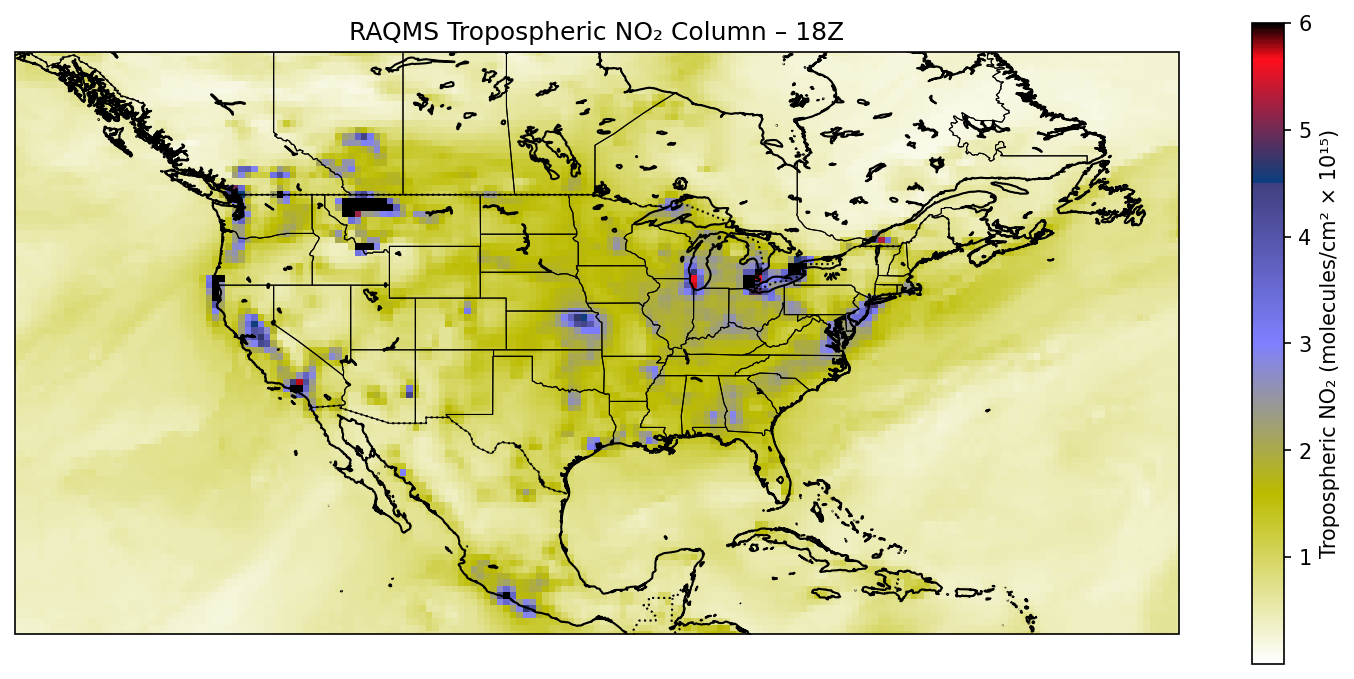

In [9]:
yt = ds["grid_yt"].values
xt = ds["grid_xt"].values
lon2d, lat2d = np.meshgrid(xt, yt)

fig = plt.figure(figsize=(10, 6), dpi=150)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-140, -50, 15, 60], crs=ccrs.PlateCarree())

ax.coastlines(resolution='10m')
ax.add_feature(cf.BORDERS, linestyle=':')
ax.add_feature(cf.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cf.STATES, linewidth=0.5)

pcm = ax.pcolormesh(lon2d, lat2d, trop_col[0, :, :], cmap='gist_stern_r', shading='auto', vmax=6)


cb = plt.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.75, pad=0.05)
cb.set_label("Tropospheric NO₂ (molecules/cm² × 10¹⁵)")

plt.title("RAQMS Tropospheric NO₂ Column – 18Z")
plt.tight_layout()
plt.show()


In [12]:
# Paths
input_dir = "/ships22/raqms/lenzen/FV3GFS.9.1.2023/OMPS.NM.CLDFR1.SZA70.TROPOMICO.VIIRSAOD.FRAC.phys2.allthin25km.allHR2DEG.ext.10x10/C192/5DEGll"
output_dir = "no2_trop_raqms"
plot_dir = "no2_trop_raqms/plots"
os.makedirs(output_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

# Load files
files = sorted(glob.glob(f"{input_dir}/tracer.202308*.5deg.ll.nc"))

# Conversion factor (ppv → molecules/cm² × 1e15)
fac = 1.e-15 * 1.0e4 * 6.023e23 / 28.97 / 9.8 / 1000.

for f in files:
    # Extract date and hour from filename: e.g., tracer.2023081818...
    filename = os.path.basename(f)
    date_str = filename.split('.')[1]       # '2023081818'
    day_str = date_str[:8]                  # '20230818'
    hour_str = date_str[8:10]               # '18'

    print(f"Processing {day_str} {hour_str}Z...")

    # Load dataset
    ds = xr.open_dataset(f)
    no2 = ds["no2"].values                    # shape: (1, level, lat, lon)
    pressure = ds["pdash"].values / 100       # Pa → hPa
    ptrop = ds["ptrop"].values / 100
    lat = ds["lat"].values
    lon = ds["lon"].values

    # Tropospheric mask: pressure > tropopause pressure
    mask = pressure > ptrop[:, None, :, :]
    no2_masked = np.where(mask, no2, np.nan)
    pressure_masked = np.where(mask, pressure, np.nan)

    # Prepare output array
    n_time, n_level, n_lat, n_lon = no2.shape
    trop_col = np.full((n_time, n_lat, n_lon), np.nan)

    for i in range(n_lat):
        for j in range(n_lon):
            no2_profile = no2_masked[0, :, i, j]
            p_profile   = pressure_masked[0, :, i, j]
            valid = np.isfinite(no2_profile) & np.isfinite(p_profile)

            if np.sum(valid) >= 2:
                idx = np.argsort(p_profile[valid])
                p_sorted = p_profile[valid][idx]
                no2_sorted = no2_profile[valid][idx]
                trop_col[0, i, j] = trapezoid(no2_sorted, p_sorted) * fac

    # Plot
    yt = ds["grid_yt"].values
    xt = ds["grid_xt"].values
    lon2d, lat2d = np.meshgrid(xt, yt)

    fig = plt.figure(figsize=(10, 6), dpi=150)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-140, -50, 15, 60], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.add_feature(cf.BORDERS, linestyle=':')
    ax.add_feature(cf.LAKES, edgecolor='black', facecolor='none')
    ax.add_feature(cf.STATES, linewidth=0.5)

    pcm = ax.pcolormesh(lon2d, lat2d, trop_col[0, :, :], cmap='gist_stern_r', shading='auto', vmax=6, transform=ccrs.PlateCarree())
    cb = plt.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.75, pad=0.05)
    cb.set_label("Tropospheric NO₂ (molecules/cm² × 10¹⁵)")
    plt.title(f"RAQMS Tropospheric NO₂ – {day_str} {hour_str}Z")
    plt.tight_layout()
    plot_filename = f"tropno2_{day_str}_{hour_str}Z.png"
    plt.savefig(os.path.join(plot_dir, plot_filename))
    plt.close()
    
    # Set time stamp
    time = np.array([datetime.strptime(date_str, "%Y%m%d%H")])

    # Create dataset
    ds_out = xr.Dataset(
        {
            "no2_trop_column": (("time", "lat", "lon"), trop_col)
        },
        coords={
            "time": time,
            "lat": (("lat", "lon"), lat.squeeze()),
            "lon": (("lat", "lon"), lon.squeeze()),
            "grid_yt": ds["grid_yt"],
            "grid_xt": ds["grid_xt"],
        }
    )
    ds_out["no2_trop_column"].attrs["units"] = "molecules/cm² × 1e15"
    ds_out["no2_trop_column"].attrs["long_name"] = "Tropospheric NO₂ column"

    # Save
    out_filename = os.path.basename(f)  # e.g., "tracer.2023080118.5deg.ll.nc"
    out_path = os.path.join(output_dir, out_filename)
    ds_out.to_netcdf(out_path)
    print(f"Saved to {out_path}")


Processing 20230801 00Z...
Saved to no2_trop_raqms/tracer.2023080100.5deg.ll.nc
Processing 20230801 06Z...
Saved to no2_trop_raqms/tracer.2023080106.5deg.ll.nc
Processing 20230801 12Z...
Saved to no2_trop_raqms/tracer.2023080112.5deg.ll.nc
Processing 20230801 18Z...
Saved to no2_trop_raqms/tracer.2023080118.5deg.ll.nc
Processing 20230802 00Z...
Saved to no2_trop_raqms/tracer.2023080200.5deg.ll.nc
Processing 20230802 06Z...
Saved to no2_trop_raqms/tracer.2023080206.5deg.ll.nc
Processing 20230802 12Z...
Saved to no2_trop_raqms/tracer.2023080212.5deg.ll.nc
Processing 20230802 18Z...
Saved to no2_trop_raqms/tracer.2023080218.5deg.ll.nc
Processing 20230803 00Z...
Saved to no2_trop_raqms/tracer.2023080300.5deg.ll.nc
Processing 20230803 06Z...
Saved to no2_trop_raqms/tracer.2023080306.5deg.ll.nc
Processing 20230803 12Z...
Saved to no2_trop_raqms/tracer.2023080312.5deg.ll.nc
Processing 20230803 18Z...
Saved to no2_trop_raqms/tracer.2023080318.5deg.ll.nc
Processing 20230804 00Z...
Saved to no2_